## Anomaly Detection - Test

Anomaly detection (also outlier detection) is the identification of items, events or observations which do not conform to an expected pattern or other items in a dataset. In this notebook, anomaly detection is done on timeseries data, by converting timeseries into a smaller latent vector and finding reconstruction loss between the reconstructed output and the input. The higher the reconstruction loss, the more chances of it being an anomaly.

**Methodology followed:**
* Use Variational Recurrent AutoEncoder (VRAE) for dimensionality reduction of the timeseries
* Reconstruct output for test_dataset and compute reconstruction loss
* Higher the score, higher the chances of it being an anomaly
* This is a classical example of Unsupervised Learning


**In this notebook:**
* Read the saved VRAE model
* Reconstruct the test_dataset using the saved model
* Compute anomaly score

**Paper:**

* [Variational Inference for On-line Anomaly Detection in High-Dimensional Time Series](https://arxiv.org/pdf/1412.6581.pdf)
* [Variational Recurrent Auto-encoders](https://arxiv.org/pdf/1602.07109.pdf)

**Author: Tejas Lodaya <br>
Version: v1 <br>**

#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Load saved model](#Load-saved-model)
3. [Compute anomaly score based on reconstruction](#Compute-anomaly-score-based-on-reconstruction)

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### Add python path

In [2]:
import sys
sys.path.append('../../')

### Import required modules

In [1]:
from clustering.vrae import VRAE
from clustering.utils import *
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from random import randint
import pandas as pd
import math
import torch

from plotly.graph_objs import *
import plotly
import matplotlib
from numpy import genfromtxt
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

ImportError: No module named 'torch'

### Input parameters

In [15]:
saved_model_path = './model_dir/chfdb_chf13_45590.pth'
test_data_file = '../../data/chfdb_chf13_45590_TEST.pkl'

### Hyper parameters

In [12]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 8
learning_rate = 0.0005
n_epochs = 10
dropout_rate = 0.0
optimizer = 'Adam' # options: ADAM, SGD
cuda = False
print_every = 1
clip = True
max_grad_norm = 5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss, ReconLoss
block = 'LSTM' # options: LSTM, GRU

### Load data and preprocess

In [16]:
df = pd.DataFrame(pd.read_pickle(test_data_file))
X_test = df.values[:, 0]
X_test = np.expand_dims(X_test, axis = 1)

**Fetch `sequence_length` from dataset**

In [17]:
sequence_length = 100

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules


In [18]:
vrae = VRAE(sequence_length=sequence_length,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block)

### Load saved model

In [19]:
vrae.load(saved_model_path)

### Compute anomaly score based on reconstruction

In [20]:
score_df = cut_and_score(X_test, vrae, batch_given = False, shift_size = sequence_length, sequence_length = sequence_length)

# If batch is given, pass `batch_given` as True.
#score_df = cut_and_score(X_test, vrae, batch_given = True)

In [21]:
score_df

start   end  anomaly_score
0       0   100       0.020360
1     100   200       0.047060
2     200   300       0.060469
3     300   400       0.029200
4     400   500       0.443807
5     500   600       0.047796
6     600   700       0.018034
7     700   800       0.041338
8     800   900       0.053209
9     900  1000       0.022234
10   1000  1100       0.030383
11   1100  1200       0.042486

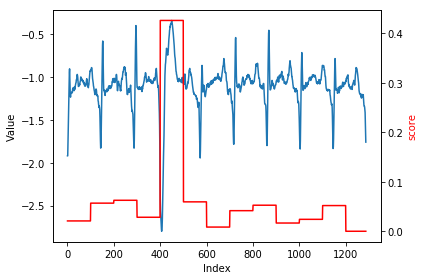

In [11]:
plot_anomaly(X_test, score_df)